## Tanzania's Waterwell Problem
This project aims to provide an overview of the water well situation in Tanzania to the Tanzanian government. The focus is on mitigating a water crisis by predicting water wells that will soon be in need of repair and planning future water well locations for maximum effectiveness.


In [1]:
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
import seaborn as sns
import pandas as pd
import numpy as np
import sys

import sklearn as sk
from sklearn import metrics
from sklearn.model_selection import train_test_split, ShuffleSplit, learning_curve, GridSearchCV
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC


In [2]:
import pandas as pd

# Load the CSV files into pandas DataFrames
trainingsetlabels = pd.read_csv('/Users/jguzzo522/Desktop/WATERWELL/trainingsetlabels.csv')
trainingsetvalues = pd.read_csv('/Users/jguzzo522/Desktop/WATERWELL/trainingsetvalues.csv')

# Display the loaded datasets

print("\nTraining Set Labels:")
print(trainingsetlabels.head())
print("\nTraining Set Values:")
print(trainingsetvalues.head())



Training Set Labels:
      id    status_group
0  69572      functional
1   8776      functional
2  34310      functional
3  67743  non functional
4  19728      functional

Training Set Values:
      id  amount_tsh date_recorded        funder  gps_height     installer  \
0  69572      6000.0    2011-03-14         Roman        1390         Roman   
1   8776         0.0    2013-03-06       Grumeti        1399       GRUMETI   
2  34310        25.0    2013-02-25  Lottery Club         686  World vision   
3  67743         0.0    2013-01-28        Unicef         263        UNICEF   
4  19728         0.0    2011-07-13   Action In A           0       Artisan   

   longitude   latitude              wpt_name  num_private  ... payment_type  \
0  34.938093  -9.856322                  none            0  ...     annually   
1  34.698766  -2.147466              Zahanati            0  ...    never pay   
2  37.460664  -3.821329           Kwa Mahundi            0  ...   per bucket   
3  38.486161 -11.

In [3]:
# Check the number of unique IDs in each dataset
training_labels_ids = set(trainingsetlabels['id'])
training_values_ids = set(trainingsetvalues['id'])


print("Number of unique IDs in Training Set Labels:", len(training_labels_ids))
print("Number of unique IDs in Training Set Values:", len(training_values_ids))


Number of unique IDs in Training Set Labels: 59400
Number of unique IDs in Training Set Values: 59400


## Merging Training Set Values

The training set values were merged to create a unified dataset, combining the features with the corresponding target variable. This consolidation facilitates easier interpretation and comparison of the data, streamlining the analysis process.

### Benefits of Merging:
- Simplifies analysis by providing a single dataset with all relevant information.
- Enables better insights into the relationships between features and the target variable.
- Facilitates the development and evaluation of predictive models.

By merging the training set values with the labels, we can now analyze the impact of different features on the condition of water wells in Tanzania more effectively. This allows us to identify key factors influencing well functionality and prioritize maintenance efforts accordingly.


In [4]:
import pandas as pd

# Load the CSV files into pandas DataFrames
training_set_labels = pd.read_csv('/Users/jguzzo522/Desktop/WATERWELL/trainingsetlabels.csv')
training_set_values = pd.read_csv('/Users/jguzzo522/Desktop/WATERWELL/trainingsetvalues.csv')

# Merge the datasets on the 'id' column
merged_data = pd.merge(training_set_values, training_set_labels, on='id', how='inner')

# Display the merged dataset
print(merged_data)


          id  amount_tsh date_recorded           funder  gps_height  \
0      69572      6000.0    2011-03-14            Roman        1390   
1       8776         0.0    2013-03-06          Grumeti        1399   
2      34310        25.0    2013-02-25     Lottery Club         686   
3      67743         0.0    2013-01-28           Unicef         263   
4      19728         0.0    2011-07-13      Action In A           0   
...      ...         ...           ...              ...         ...   
59395  60739        10.0    2013-05-03  Germany Republi        1210   
59396  27263      4700.0    2011-05-07      Cefa-njombe        1212   
59397  37057         0.0    2011-04-11              NaN           0   
59398  31282         0.0    2011-03-08            Malec           0   
59399  26348         0.0    2011-03-23       World Bank         191   

          installer  longitude   latitude              wpt_name  num_private  \
0             Roman  34.938093  -9.856322                  none    

In [5]:

# Display the first few rows of the merged dataset
merged_data.head()



,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,...,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group
0,69572,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,0,...,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe,functional
1,8776,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,...,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional
2,34310,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,...,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe,functional
3,67743,0.0,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,...,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe,non functional
4,19728,0.0,2011-07-13,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,0,...,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional


In [6]:
# Load the test set values dataset
test_set_values = pd.read_csv('/Users/jguzzo522/Desktop/WATERWELL/testsetvalues.csv')

# Print out the test set values dataset
print(test_set_values)


          id  amount_tsh date_recorded                  funder  gps_height  \
0      50785         0.0    2013-02-04                    Dmdd        1996   
1      51630         0.0    2013-02-04  Government Of Tanzania        1569   
2      17168         0.0    2013-02-01                     NaN        1567   
3      45559         0.0    2013-01-22              Finn Water         267   
4      49871       500.0    2013-03-27                  Bruder        1260   
...      ...         ...           ...                     ...         ...   
14845  39307         0.0    2011-02-24                  Danida          34   
14846  18990      1000.0    2011-03-21                    Hiap           0   
14847  28749         0.0    2013-03-04                     NaN        1476   
14848  33492         0.0    2013-02-18                 Germany         998   
14849  68707         0.0    2013-02-13  Government Of Tanzania         481   

        installer  longitude   latitude                 wpt_nam

## Exploring the data


In [7]:
# Get the number of unique values for each column in the merged dataset
unique_values_counts = merged_data.nunique()

# Display the number of unique values for each column
print(unique_values_counts)


id                       59400
amount_tsh                  98
date_recorded              356
funder                    1897
gps_height                2428
installer                 2145
longitude                57516
latitude                 57517
wpt_name                 37400
num_private                 65
basin                        9
subvillage               19287
region                      21
region_code                 27
district_code               20
lga                        125
ward                      2092
population                1049
public_meeting               2
recorded_by                  1
scheme_management           12
scheme_name               2696
permit                       2
construction_year           55
extraction_type             18
extraction_type_group       13
extraction_type_class        7
management                  12
management_group             5
payment                      7
payment_type                 7
water_quality                8
quality_

## Changing the Dependent Variable 'status_group' from a t to a Binary 

This makes the dataset more manageable and will allow for for ROC Curves, and F1 scores
Merging of 'Functional' and 'Function Needs Repair'



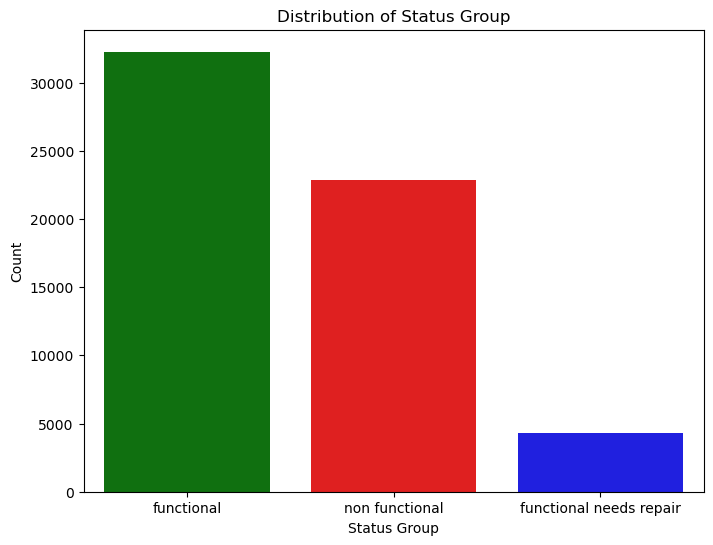

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set the color palette for each category
color_palette = {'functional': 'green', 'functional needs repair': 'blue', 'non functional': 'red'}

# Set figure size
plt.figure(figsize=(8, 6))

# Plot the counts of each category with custom colors
sns.countplot(data=merged_data, x='status_group', palette=color_palette)

# Add labels and title
plt.title('Distribution of Status Group')
plt.xlabel('Status Group')
plt.ylabel('Count')

# Show plot
plt.show()


In [9]:
# Combine 'functional' and 'functional needs repair' as positive class
merged_data['status_group_binary'] = np.where(
    merged_data['status_group'].isin(['functional', 'functional needs repair']), 1, 0
)

# Drop the original 'status_group' column
merged_data.drop(columns=['status_group'], inplace=True)

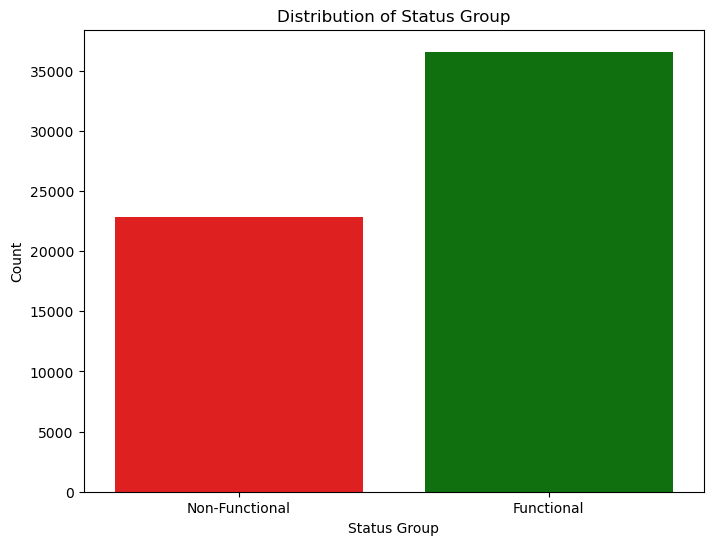

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set figure size
plt.figure(figsize=(8, 6))

# Define color palette
color_palette = {1: 'green', 0: 'red'}

# Plot the counts of each category with custom colors
sns.countplot(data=merged_data, x='status_group_binary', palette=color_palette)

# Set the x-axis tick labels
plt.xticks(ticks=[1, 0], labels=['Functional', 'Non-Functional'])

# Add labels and title
plt.title('Distribution of Status Group')
plt.xlabel('Status Group')
plt.ylabel('Count')

# Show plot
plt.show()


## Removal of "columns

#### Funder
The column "funder" contains a large number of unique values (1897). Attempting to analyze how 1897 different companies or individuals funded the water wells would be very time-consuming and might not provide significant insights due to the sheer volume of categories. Therefore, we have opted to remove the "funder_x" variable from our dataset to streamline our analysis and focus on other variables with potentially more significant impact on our predictive modeling.



In [11]:
# Count the number of unique values
num_unique_values = merged_data['funder'].nunique()

# Display the number of unique values
print("Number of unique values:", num_unique_values)

# Display the unique values
unique_values = merged_data['funder'].unique()
print("Unique values:")
print(unique_values)


Number of unique values: 1897
Unique values:
['Roman' 'Grumeti' 'Lottery Club' ... 'Dina' 'Brown' 'Samlo']


In [12]:
# Drop the "funder" column
merged_data.drop(columns=['funder'], inplace=True)


#### 'Subvillage'

In the initial exploration of our dataset, we identified the "subvillage" feature, which represents the geographic location of each waterpoint at a subvillage level. However, upon closer examination, we observed that this feature contains a large number of unique values (19,287). While capturing detailed geographic information is important for understanding the distribution of waterpoints, including such granular data in our predictive modeling may not yield meaningful insights and could introduce unnecessary complexity to our analysis.


In [13]:
# Drop the "subvillage" column
merged_data.drop(columns=['subvillage'], inplace=True)


#### 'Wpt_name'

The "wpt_name" column contains a large number of unique values (37,400), representing different names of waterpoints. Similar to the decision to drop the "subvillage" column, the high cardinality of this feature could potentially lead to overfitting, increased model complexity, and reduced interpretability without significantly enhancing predictive performance. Given the sheer number of distinct names and the potential for noise or redundancy in the data, it's prudent to exclude this column from our analysis to maintain simplicity and focus on features with more meaningful predictive value.

In [14]:
# Drop the "wpt_name" column
merged_data.drop(columns=['wpt_name'], inplace=True)


#### 'Scheme_name'

Upon examining the dataset, it is evident that both 'scheme_management' and 'scheme_name' represent the entity responsible for operating the waterpoint. However, 'scheme_management' contains only 12 unique values, whereas 'scheme_name' has 2696 unique values. Given that 'scheme_management' provides a more concise categorization with fewer unique values, we have decided to retain this variable and drop 'scheme_name' for simplicity and ease of analysis.

In [15]:
# Drop the "scheme_name" column
merged_data.drop(columns=['scheme_name'], inplace=True)

#### 'Installer'
The 'installer' column contains a large number of unique values (2146), indicating a wide variety of organizations or individuals responsible for installing waterpoints. Analyzing each unique installer would be cumbersome and may not significantly contribute to our predictive modeling efforts. Furthermore, the identity of the installer might not have a direct impact on the functionality of waterpoints. Therefore, removing this column streamlines our dataset, focusing on more relevant features for predictive modeling.

In [16]:
# Check the number of unique values in the 'installer' column
num_unique_installers = len(merged_data['installer'].unique())
print("Number of unique installers:", num_unique_installers)

# Display some of the unique values in the 'installer' column
unique_installers = merged_data['installer'].unique()
print("Unique installers:", unique_installers[:10])  # Displaying the first 10 unique values


Number of unique installers: 2146
Unique installers: ['Roman' 'GRUMETI' 'World vision' 'UNICEF' 'Artisan' 'DWE' 'DWSP'
 'Water Aid' 'Private' 'DANIDA']


In [17]:
# Drop the "installer" column
merged_data.drop(columns=['installer'], inplace=True)


#### 'Mangement'
Upon examining the dataset, it became apparent that both 'management' and 'management_group' convey information about the entity responsible for operating the waterpoint. However, 'management' encompasses a wider range of specific entities, resulting in 12 unique values, while 'management_group' provides a broader categorization with 5 unique values. Given that 'management_group' offers a more generalized classification and is easier to interpret, especially for predictive modeling, we have chosen to retain it and discard 'management'. This decision streamlines the dataset, making it more manageable for analysis and modeling purposes.

In [18]:
unique_management_values = merged_data['management'].unique()
unique_management_group_values = merged_data['management_group'].unique()

print("Unique values in 'management':")
print(unique_management_values)

print("\nUnique values in 'management_group':")
print(unique_management_group_values)


Unique values in 'management':
['vwc' 'wug' 'other' 'private operator' 'water board' 'wua' 'company'
 'water authority' 'parastatal' 'unknown' 'other - school' 'trust']

Unique values in 'management_group':
['user-group' 'other' 'commercial' 'parastatal' 'unknown']


In [19]:
# Drop the "managment" column
merged_data.drop(columns=['management'], inplace=True)

#### 'Waterpoint_type_group'

Upon examining the unique values in the 'waterpoint_type' and 'waterpoint_type_group' columns, it's apparent that both columns represent categories of waterpoints, but 'waterpoint_type' provides more detailed distinctions with seven unique values, while 'waterpoint_type_group' aggregates these into six categories.

Considering the potential significance of the distinctions between different types of waterpoints, it may be beneficial to retain the column with more granular information ('waterpoint_type') and drop the column with fewer unique values ('waterpoint_type_group'). By doing so, we maintain a more detailed representation of the types of waterpoints in the dataset, which could potentially offer more insights during analysis or modeling.

Therefore, we have decided to drop the 'waterpoint_type_group' column to streamline the dataset while preserving the detailed categorization provided by the 'waterpoint_type' column.


In [20]:
# Unique values in 'waterpoint_type'
print("Unique values in 'waterpoint_type':")
print(merged_data['waterpoint_type'].unique())

# Unique values in 'waterpoint_type_group'
print("\nUnique values in 'waterpoint_type_group':")
print(merged_data['waterpoint_type_group'].unique())


Unique values in 'waterpoint_type':
['communal standpipe' 'communal standpipe multiple' 'hand pump' 'other'
 'improved spring' 'cattle trough' 'dam']

Unique values in 'waterpoint_type_group':
['communal standpipe' 'hand pump' 'other' 'improved spring'
 'cattle trough' 'dam']


In [21]:
# Drop the "waterpoint_type_group" column
merged_data.drop(columns=['waterpoint_type_group'], inplace=True)

#### 'Quantity_group'
Upon examination, it was clear these two columns were identical. Therefore it was appropriate to remove one column and so 'quantity_group' was dropped.

In [22]:
print("Unique values in 'quantity':")
print(merged_data['quantity'].unique())

print("\nUnique values in 'quantity_group':")
print(merged_data['quantity_group'].unique())
print("Number of NaN values in 'quantity':", merged_data['quantity'].isna().sum())
print("Number of NaN values in 'quantity_group':", merged_data['quantity_group'].isna().sum())



Unique values in 'quantity':
['enough' 'insufficient' 'dry' 'seasonal' 'unknown']

Unique values in 'quantity_group':
['enough' 'insufficient' 'dry' 'seasonal' 'unknown']
Number of NaN values in 'quantity': 0
Number of NaN values in 'quantity_group': 0


In [23]:
# Drop the "quantity_group" column
merged_data.drop(columns=['quantity_group'], inplace=True)

#### 'Quality_group'

Upon examining the unique values in the 'water_quality and 'quality_group' columns, it's apparent that both columns represent the quality of water, but 'water_quality' provides more detailed distinctions with eight unique values, while 'quality_group' aggregates these into six categories.

Considering the potential significance of the distinctions between different types of water quality, it may be beneficial to retain the column with more granular information ('wate_quality') and drop the column with fewer unique values ('quality_group'). By doing so, we maintain a more detailed representation of the types of quality of water in the dataset, which could potentially offer more insights during analysis or modeling.

In [24]:
print("Unique values in 'water_quality':")
print(merged_data['water_quality'].unique())

print("\nUnique values in 'quality_group':")
print(merged_data['quality_group'].unique())
print("Number of NaN values in 'water_quality':", merged_data['water_quality'].isna().sum())
print("Number of NaN values in 'quality_group':", merged_data['quality_group'].isna().sum())


Unique values in 'water_quality':
['soft' 'salty' 'milky' 'unknown' 'fluoride' 'coloured' 'salty abandoned'
 'fluoride abandoned']

Unique values in 'quality_group':
['good' 'salty' 'milky' 'unknown' 'fluoride' 'colored']
Number of NaN values in 'water_quality': 0
Number of NaN values in 'quality_group': 0


In [25]:
# Count occurrences of 'unknown' in 'water_quality'
unknown_water_quality_count = merged_data['water_quality'].value_counts().get('unknown', 0)

# Count occurrences of 'unknown' in 'quality_group'
unknown_quality_group_count = merged_data['quality_group'].value_counts().get('unknown', 0)

print("Number of 'unknown' values in 'water_quality':", unknown_water_quality_count)
print("Number of 'unknown' values in 'quality_group':", unknown_quality_group_count)


Number of 'unknown' values in 'water_quality': 1876
Number of 'unknown' values in 'quality_group': 1876


In [26]:
# Drop the "quantity_group" column
merged_data.drop(columns=['quality_group'], inplace=True)

#### 'recorded_by'

The 'recorded_by' column contains only one unique value, indicating that all records in the dataset were recorded by the same entity or group. Since this column does not offer any variability or meaningful information for analysis, it does not contribute to our predictive modeling task. Therefore, removing it simplifies the dataset without sacrificing any relevant information, making it more efficient for further analysis and model building.

In [27]:
# Drop the 'recorded_by' column
merged_data.drop(columns=['recorded_by'], inplace=True)


#### 'payment_type'
Upon examination, it was clear these two columns were identical. Therefore it was appropriate to remove one column and so 'payment_type' was dropped.

In [28]:
print("Unique values in 'payment':")
print(merged_data['payment'].unique())

print("\nUnique values in 'payment_type':")
print(merged_data['payment_type'].unique())
print("Number of NaN values in 'payment':", merged_data['payment'].isna().sum())
print("Number of NaN values in 'payment_type':", merged_data['payment_type'].isna().sum())


Unique values in 'payment':
['pay annually' 'never pay' 'pay per bucket' 'unknown'
 'pay when scheme fails' 'other' 'pay monthly']

Unique values in 'payment_type':
['annually' 'never pay' 'per bucket' 'unknown' 'on failure' 'other'
 'monthly']
Number of NaN values in 'payment': 0
Number of NaN values in 'payment_type': 0


In [29]:
# Drop the "payment_type" column
merged_data.drop(columns=['payment_type'], inplace=True)

#### 'Source_type' and 'Source_class'
Upon examining the unique values in the 'source_type', 'source', 'source_class' columns, it's apparent that these columns represent the source of water, but 'source' provides more detailed distinctions with ten unique values, while 'source_type' has only seven catagories, and 'source_class' only has 3.

Considering the potential significance of the distinctions between different sources of water, it may be beneficial to retain the column with more information ('source') and drop the other two column with fewer unique values ('source_type' and 'source_class). 

In [30]:
# Unique values for source_type
print("Unique values in 'source_type':")
print(merged_data['source_type'].unique())

# Unique values for source
print("Unique values in 'source':")
print(merged_data['source'].unique())


# Unique values for source_class
print("Unique values in 'source_class':")
print(merged_data['source_class'].unique())

Unique values in 'source_type':
['spring' 'rainwater harvesting' 'dam' 'borehole' 'other' 'shallow well'
 'river/lake']
Unique values in 'source':
['spring' 'rainwater harvesting' 'dam' 'machine dbh' 'other'
 'shallow well' 'river' 'hand dtw' 'lake' 'unknown']
Unique values in 'source_class':
['groundwater' 'surface' 'unknown']


In [31]:
# Drop the 'source_type' column
merged_data.drop(columns=['source_type'], inplace=True)
# Drop the 'source_class' column
merged_data.drop(columns=['source_class'], inplace=True)

#### 'Extraction_type_group' and 'Extraction_type_class'
Upon examining the dataset, it's evident that the 'extraction_type' column provides a more detailed categorization with a wider range of variables compared to 'extraction_type_group' and 'extraction_type_class'. While 'extraction_type' contains 18 unique values, 'extraction_type_group' and 'extraction_type_class' have fewer categories, potentially resulting in loss of information. Hence, we have decided to retain 'extraction_type' and drop the other two columns for a more comprehensive analysis.


In [32]:
# Unique values in 'extraction_type'
print("Unique values in 'extraction_type':")
print(merged_data['extraction_type'].unique())

# Unique values in 'extraction_type_group'
print("\nUnique values in 'extraction_type_group':")
print(merged_data['extraction_type_group'].unique())

# Unique values in 'extraction_type_class'
print("\nUnique values in 'extraction_type_class':")
print(merged_data['extraction_type_class'].unique())


Unique values in 'extraction_type':
['gravity' 'submersible' 'swn 80' 'nira/tanira' 'india mark ii' 'other'
 'ksb' 'mono' 'windmill' 'afridev' 'other - rope pump' 'india mark iii'
 'other - swn 81' 'other - play pump' 'cemo' 'climax' 'walimi'
 'other - mkulima/shinyanga']

Unique values in 'extraction_type_group':
['gravity' 'submersible' 'swn 80' 'nira/tanira' 'india mark ii' 'other'
 'mono' 'wind-powered' 'afridev' 'rope pump' 'india mark iii'
 'other handpump' 'other motorpump']

Unique values in 'extraction_type_class':
['gravity' 'submersible' 'handpump' 'other' 'motorpump' 'wind-powered'
 'rope pump']


In [33]:
# Drop 'extraction_type_group' and 'extraction_type_class'
merged_data.drop(columns=['extraction_type_group', 'extraction_type_class'], inplace=True)


In [34]:
print("Unique values in 'region_code':")
print(merged_data['region_code'].unique())

print("\nUnique values in 'district_code':")
print(merged_data['district_code'].unique())


Unique values in 'region_code':
[11 20 21 90 18  4 17 14 60 10  3 15 19 16 80  1  6  2 12 13  5  7 99 24
  9  8 40]

Unique values in 'district_code':
[ 5  2  4 63  1  8  3  6 43  7 23 33 53 62 60 30 13  0 80 67]


In [35]:
# Display the first few rows of the merged dataset
merged_data.head()


,id,amount_tsh,date_recorded,gps_height,longitude,latitude,num_private,basin,region,region_code,...,permit,construction_year,extraction_type,management_group,payment,water_quality,quantity,source,waterpoint_type,status_group_binary
0,69572,6000.0,2011-03-14,1390,34.938093,-9.856322,0,Lake Nyasa,Iringa,11,...,False,1999,gravity,user-group,pay annually,soft,enough,spring,communal standpipe,1
1,8776,0.0,2013-03-06,1399,34.698766,-2.147466,0,Lake Victoria,Mara,20,...,True,2010,gravity,user-group,never pay,soft,insufficient,rainwater harvesting,communal standpipe,1
2,34310,25.0,2013-02-25,686,37.460664,-3.821329,0,Pangani,Manyara,21,...,True,2009,gravity,user-group,pay per bucket,soft,enough,dam,communal standpipe multiple,1
3,67743,0.0,2013-01-28,263,38.486161,-11.155298,0,Ruvuma / Southern Coast,Mtwara,90,...,True,1986,submersible,user-group,never pay,soft,dry,machine dbh,communal standpipe multiple,0
4,19728,0.0,2011-07-13,0,31.130847,-1.825359,0,Lake Victoria,Kagera,18,...,True,0,gravity,other,never pay,soft,seasonal,rainwater harvesting,communal standpipe,1


#### 'Ward' and 'lga'

These columns had alot of individual values, and distric code had less. The geographical information was obtainied by the region instead. 

In [36]:
# Drop 'ward' and 'lga'
merged_data.drop(columns=['ward', 'lga'], inplace=True)


In [37]:
# Display the first few rows of the merged dataset
merged_data.head()




,id,amount_tsh,date_recorded,gps_height,longitude,latitude,num_private,basin,region,region_code,...,permit,construction_year,extraction_type,management_group,payment,water_quality,quantity,source,waterpoint_type,status_group_binary
0,69572,6000.0,2011-03-14,1390,34.938093,-9.856322,0,Lake Nyasa,Iringa,11,...,False,1999,gravity,user-group,pay annually,soft,enough,spring,communal standpipe,1
1,8776,0.0,2013-03-06,1399,34.698766,-2.147466,0,Lake Victoria,Mara,20,...,True,2010,gravity,user-group,never pay,soft,insufficient,rainwater harvesting,communal standpipe,1
2,34310,25.0,2013-02-25,686,37.460664,-3.821329,0,Pangani,Manyara,21,...,True,2009,gravity,user-group,pay per bucket,soft,enough,dam,communal standpipe multiple,1
3,67743,0.0,2013-01-28,263,38.486161,-11.155298,0,Ruvuma / Southern Coast,Mtwara,90,...,True,1986,submersible,user-group,never pay,soft,dry,machine dbh,communal standpipe multiple,0
4,19728,0.0,2011-07-13,0,31.130847,-1.825359,0,Lake Victoria,Kagera,18,...,True,0,gravity,other,never pay,soft,seasonal,rainwater harvesting,communal standpipe,1


In [38]:
# Get the list of columns for merged_data
merged_data_columns = merged_data.columns.tolist()



# Display the columns for both datasets
print("Columns in merged_data:", merged_data_columns)



Columns in merged_data: ['id', 'amount_tsh', 'date_recorded', 'gps_height', 'longitude', 'latitude', 'num_private', 'basin', 'region', 'region_code', 'district_code', 'population', 'public_meeting', 'scheme_management', 'permit', 'construction_year', 'extraction_type', 'management_group', 'payment', 'water_quality', 'quantity', 'source', 'waterpoint_type', 'status_group_binary']


## Reviewing Datasets for Missing and Duplicate Data

Reviewing the datasets for missing or duplicate data is important to ensure data reliability. 

In [39]:
# Count missing values in merged_data
missing_merged_data = merged_data.isnull().sum()
print("Missing values in merged_data:")
print(missing_merged_data)
# Check for duplicates in merged_data
duplicate_rows = merged_data.duplicated()
print("Number of duplicate rows in merged_data:", duplicate_rows.sum())


Missing values in merged_data:
id                        0
amount_tsh                0
date_recorded             0
gps_height                0
longitude                 0
latitude                  0
num_private               0
basin                     0
region                    0
region_code               0
district_code             0
population                0
public_meeting         3334
scheme_management      3877
permit                 3056
construction_year         0
extraction_type           0
management_group          0
payment                   0
water_quality             0
quantity                  0
source                    0
waterpoint_type           0
status_group_binary       0
dtype: int64
Number of duplicate rows in merged_data: 0


## Handling Missing Data with KNN Imputation

To address missing values in the `construction_year` column, I opted to utilize KNN (K-Nearest Neighbors) imputation. KNN imputation is a technique used to estimate missing values in a dataset by considering the values of nearby data points. 

In this context, KNN imputation will estimate the missing construction years based on the construction years of neighboring data points. By leveraging the similarity of neighboring observations, KNN imputation provides a reasonable approximation of the missing values.

The `neighbors` parameter in KNN imputation determines the number of neighboring data points to consider when imputing missing values. I chose `neighbors=5`, which is a common choice and typically provides a good balance between accuracy and computational efficiency.

Using KNN imputation allows us to retain more data and preserve the integrity of the dataset for subsequent analysis and modeling. However, it's essential to note that KNN imputation assumes that similar observations have similar values for the missing variable, which may not always hold true in practice. Therefore, the imputed values should be interpreted with caution.

In [40]:
construction_years = merged_data['construction_year'].value_counts().sort_index()
print("Construction Years:")
print(construction_years)


Construction Years:
0       20709
1960      102
1961       21
1962       30
1963       85
1964       40
1965       19
1966       17
1967       88
1968       77
1969       59
1970      411
1971      145
1972      708
1973      184
1974      676
1975      437
1976      414
1977      202
1978     1037
1979      192
1980      811
1981      238
1982      744
1983      488
1984      779
1985      945
1986      434
1987      302
1988      521
1989      316
1990      954
1991      324
1992      640
1993      608
1994      738
1995     1014
1996      811
1997      644
1998      966
1999      979
2000     2091
2001      540
2002     1075
2003     1286
2004     1123
2005     1011
2006     1471
2007     1587
2008     2613
2009     2533
2010     2645
2011     1256
2012     1084
2013      176
Name: construction_year, dtype: int64


In [41]:
from sklearn.impute import KNNImputer

# Step 1: Perform KNN imputation on the construction_year column
imputer = KNNImputer(n_neighbors=5)  

# Replace missing values with NaN
merged_data.loc[merged_data['construction_year'] == 0, 'construction_year'] = np.nan

# Apply KNN imputation
merged_data_imputed = imputer.fit_transform(merged_data[['construction_year']])

# Replace the original construction year column with the imputed values
merged_data['construction_year'] = merged_data_imputed

# Step 2: Categorize construction years into decades
# Define the ranges for each decade
decade_ranges = {
    '1960s': range(1960, 1970),
    '1970s': range(1970, 1980),
    '1980s': range(1980, 1990),
    '1990s': range(1990, 2000),
    '2000s': range(2000, 2010),
    '2010s': range(2010, 2020)
}

# Function to categorize construction years into decades
def categorize_decade(year):
    for decade, year_range in decade_ranges.items():
        if year in year_range:
            return decade
    return 'Unknown'

# Create a new column for the decade
merged_data['decade_construction'] = merged_data['construction_year'].apply(categorize_decade)

# Display the unique values in the new decade column
unique_decades = merged_data['decade_construction'].unique()
print(unique_decades)


['1990s' '2010s' '2000s' '1980s' 'Unknown' '1970s' '1960s']


In [42]:
# Round the construction years to the nearest whole number
merged_data['construction_year'] = round(merged_data['construction_year'])

# Recategorize construction years into decades
merged_data['decade_construction'] = merged_data['construction_year'].apply(categorize_decade)

# Display the count of construction years falling into each decade
print("Count of Construction Years by Decade:")
for decade in unique_decades:
    count = merged_data[merged_data['decade_construction'] == decade].shape[0]
    print(f"{decade}: {count}")

Count of Construction Years by Decade:
1990s: 28387
2010s: 5161
2000s: 15330
1980s: 5578
Unknown: 0
1970s: 4406
1960s: 538


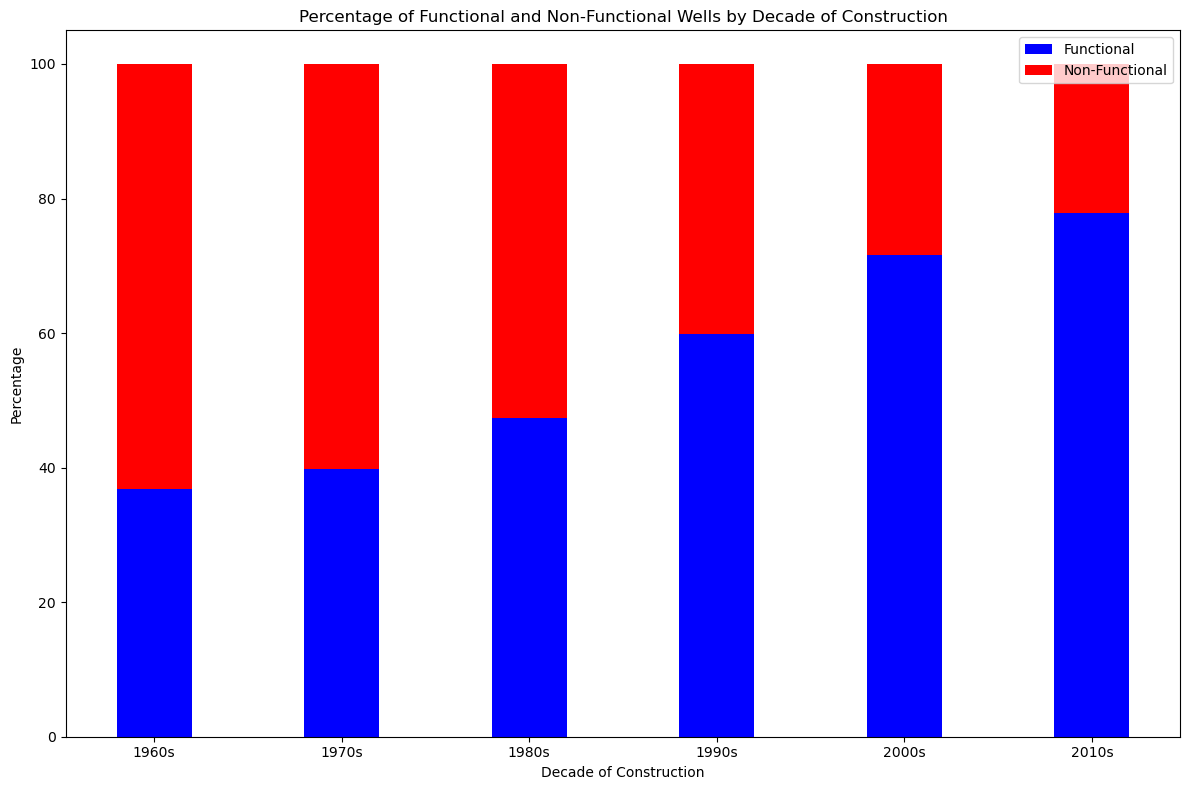

In [43]:
import matplotlib.pyplot as plt

# Calculate the total count of wells for each decade category
decade_total_counts = merged_data['decade_construction'].value_counts()

# Group the dataset by decade category and status group, then count the number of wells in each group
decade_status_counts = merged_data.groupby(['decade_construction', 'status_group_binary']).size().unstack(fill_value=0)

# Calculate the percentage of functional and non-functional wells within each decade category
decade_percentages = decade_status_counts.div(decade_total_counts, axis=0) * 100

# Extract decades and status groups
decades = decade_percentages.index
status_groups = decade_percentages.columns

# Define bar width
bar_width = 0.4
index = range(len(decades))

# Plotting
plt.figure(figsize=(12, 8))

# Plot stacked bars for functional and non-functional wells for each decade category
plt.bar(index, decade_percentages[1], bar_width, color='b', label='Functional')
plt.bar(index, decade_percentages[0], bar_width, color='r', bottom=decade_percentages[1], label='Non-Functional')

# Add labels, title, legend, and adjust layout
plt.xlabel('Decade of Construction')
plt.ylabel('Percentage')
plt.title('Percentage of Functional and Non-Functional Wells by Decade of Construction')
plt.xticks(index, decades)
plt.legend()
plt.tight_layout()
plt.show()



In [44]:
# Total number of values in each column
total_values = len(merged_data)
column_value_counts = merged_data.count()

# Percentage of missing values for public_meeting, scheme_management, and permit
missing_percentages = {
    'public_meeting': (total_values - column_value_counts['public_meeting']) / total_values * 100,
    'scheme_management': (total_values - column_value_counts['scheme_management']) / total_values * 100,
    'permit': (total_values - column_value_counts['permit']) / total_values * 100
}

print("Total number of values in each column:")
print(column_value_counts)
print("\nPercentage of missing values:")
print(missing_percentages)


Total number of values in each column:
id                     59400
amount_tsh             59400
date_recorded          59400
gps_height             59400
longitude              59400
latitude               59400
num_private            59400
basin                  59400
region                 59400
region_code            59400
district_code          59400
population             59400
public_meeting         56066
scheme_management      55523
permit                 56344
construction_year      59400
extraction_type        59400
management_group       59400
payment                59400
water_quality          59400
quantity               59400
source                 59400
waterpoint_type        59400
status_group_binary    59400
decade_construction    59400
dtype: int64

Percentage of missing values:
{'public_meeting': 5.612794612794613, 'scheme_management': 6.526936026936027, 'permit': 5.144781144781145}


## Data Cleaning

After further review, I decided to drop rows with missing values in the columns `public_meeting`, `scheme_management`, and `permit`. Although these missing values constituted a small percentage of the remaining data, it was necessary to ensure the reliability of the dataset for analysis and modeling purposes.

The decision to drop rows with missing values was made after careful consideration of the potential impact on the integrity of the data and the significance of the missing values relative to the size of the dataset.



In [45]:
# Drop rows with missing values in specified columns
merged_data.dropna(subset=['public_meeting', 'scheme_management', 'permit'], inplace=True)


There was no obvious outliers or missing data from 'date_recorded' column. However, upon further review there weren't many years and therefore this datat was not very useful. This column was removed from the train and test data. Futher anyaliss may be needed here for seasons. Possible addtion of this column for second model.

In [46]:
# Drop 'date_recorded

merged_data.drop(columns=['date_recorded'], inplace=True)


In [47]:
 
gps_height_merged = merged_data['gps_height'].value_counts().sort_index()
print("Gps Height Merged:")
print(gps_height_merged)

Gps Height Merged:
-90      1
-63      2
-59      1
-57      1
-55      1
        ..
 2623    1
 2626    2
 2627    1
 2628    1
 2770    1
Name: gps_height, Length: 2426, dtype: int64


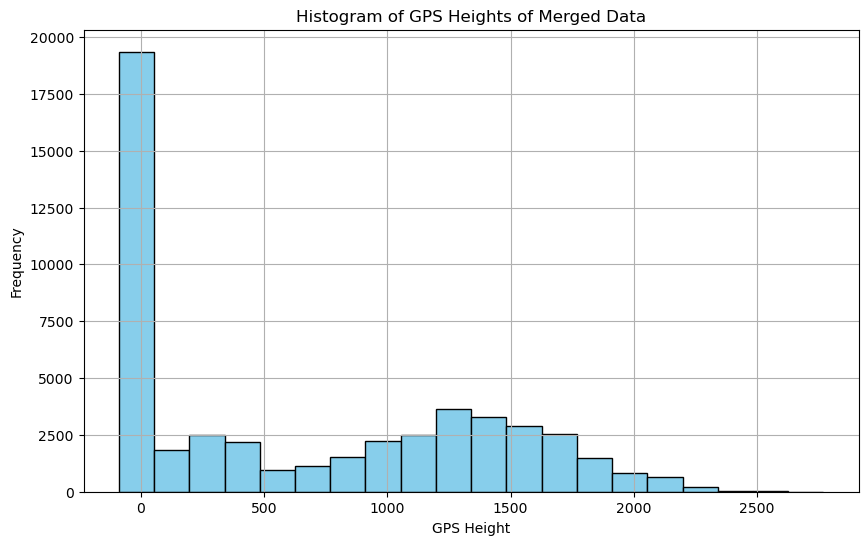

In [48]:
import matplotlib.pyplot as plt

# Plot histogram of GPS heights
plt.figure(figsize=(10, 6))
plt.hist(merged_data['gps_height'], bins=20, color='skyblue', edgecolor='black')
plt.xlabel('GPS Height')
plt.ylabel('Frequency')
plt.title('Histogram of GPS Heights of Merged Data')
plt.grid(True)
plt.show()

In [49]:
# Define function to categorize GPS heights into subcategories
def categorize_gps_heightm(height):
    if height <= 0:
        return '0 and below'
    elif height <= 500:
        return '0-500'
    elif height <= 1000:
        return '500-1000'
    elif height <= 1500:
        return '1000-1500'
    elif height <= 2000:
        return '1500-2000'
    else:
        return '2000+'

# Apply categorization function to GPS heights and create a new column for subcategories
merged_data['gps_height_categorym'] = merged_data['gps_height'].apply(categorize_gps_heightm)

# Display unique values in the new GPS height category column
unique_categories = merged_data['gps_height_categorym'].unique()
print(unique_categories)
# Group the dataset by GPS height category and display the values in each group
gps_height_groupsm = merged_data.groupby('gps_height_categorym')['gps_height'].unique()

# Display the values in each group
for category, values in gps_height_groupsm.items():
    print(f"Values in {category}:")
    print(values)
    print()
# Count the occurrences of each GPS height subcategory
gps_height_countsm = merged_data['gps_height_categorym'].value_counts()

# Display the counts
print(gps_height_countsm)

['1000-1500' '500-1000' '0-500' '0 and below' '1500-2000' '2000+']
Values in 0 and below:
[  0 -41 -15 -21 -16 -19 -25 -45 -32 -24 -39 -17  -5 -38 -37 -30  -7  -1
 -23 -12 -13 -40 -20 -11  -8  -4  -3 -42 -18 -14 -47 -22 -27  -6 -54  -9
 -28 -36  -2 -26 -31 -44 -33 -29 -35 -48 -10 -46 -51 -59 -63 -34 -49 -43
 -50 -55 -53 -57 -52 -90]

Values in 0-500:
[263  62 200 180 240 190 406 427 159 212  18  98 445  11 471 385 350 101
 262 217 183 128 232 205 120 373 102 165 357 338 326 201 334 290 237 482
 330 480 161 226 260 356 442 459 362 486 375 466  57  74  30 118 277 266
 241 306 206 288 332  19 386 104 363  93  28 495 317  72 366  45  15 458
  99 140 360 316 289 281 294 178 189 421 109  27 284 286 439 328 282 238
 340 231 223 235 207 403 270 369 242   6 474 372 150 323 123 425  54 353
 202  43  35 287  36  91 428 309 278  94 337 314  20  41 245 142  53 387
  50 380 196   1 443 261  87 148 132  66 320 293 303  26 484 319 296 346
 405 313 177 265 447 300  82 460 108 412 295 348 351 181 343 25

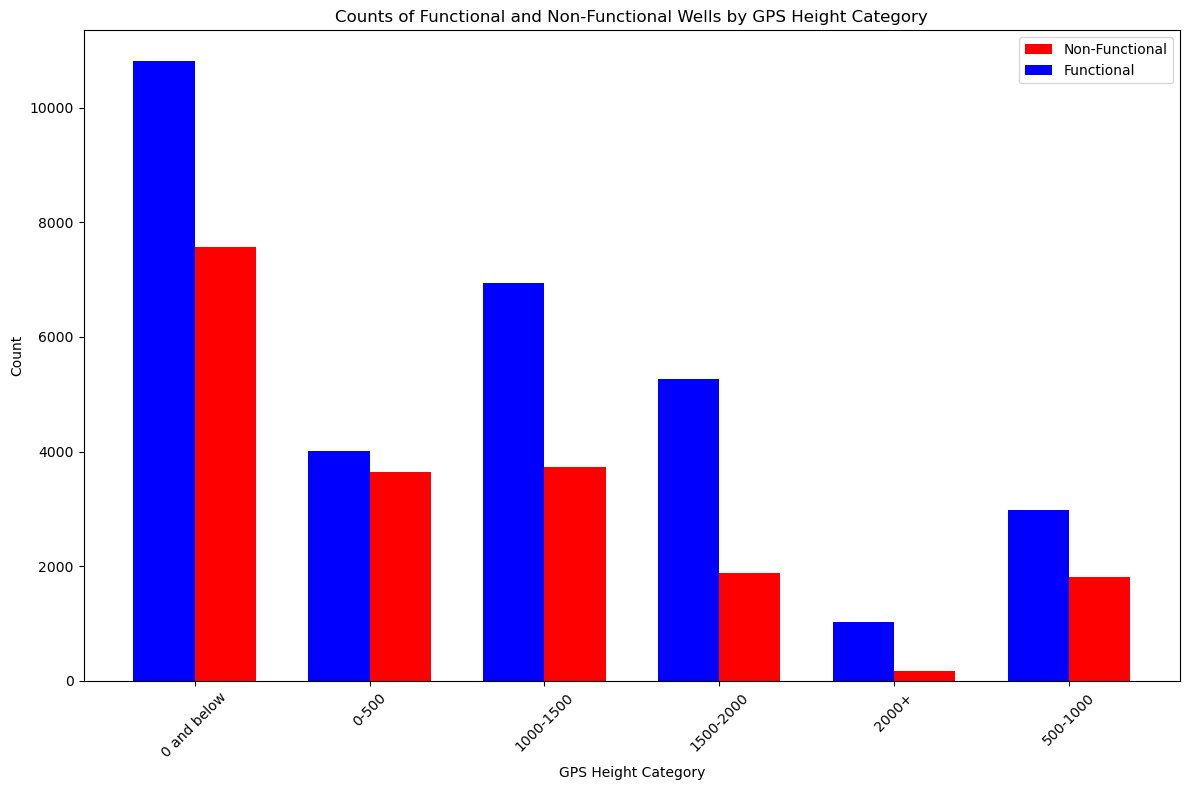

In [50]:
import matplotlib.pyplot as plt
import numpy as np

# Group the dataset by GPS height category and status group, then count the number of wells in each group
gps_height_status_countsm = merged_data.groupby(['gps_height_categorym', 'status_group_binary']).size().unstack(fill_value=0)

# Extract categories and status groups
categories = gps_height_status_countsm.index
status_groups = gps_height_status_countsm.columns

# Define bar width
bar_width = 0.35
index = np.arange(len(categories))

# Plotting
plt.figure(figsize=(12, 8))




# Plot bars for non-functional wells (using red color), offsetting them by bar width to create grouped bar chart
plt.bar(index + bar_width, gps_height_status_countsm[0], bar_width, color='r', label='Non-Functional')
# Plot bars for functional wells (using blue color)
plt.bar(index, gps_height_status_countsm[1], bar_width, color='b', label='Functional')


# Add labels, title, legend, and adjust layout
plt.xlabel('GPS Height Category')
plt.ylabel('Count')
plt.title('Counts of Functional and Non-Functional Wells by GPS Height Category')
plt.xticks(index + bar_width / 2, categories, rotation=45)  # Labeling x-axis ticks with categories
plt.legend()  # Adding legend to differentiate between blue and red bars
plt.tight_layout()
plt.show()



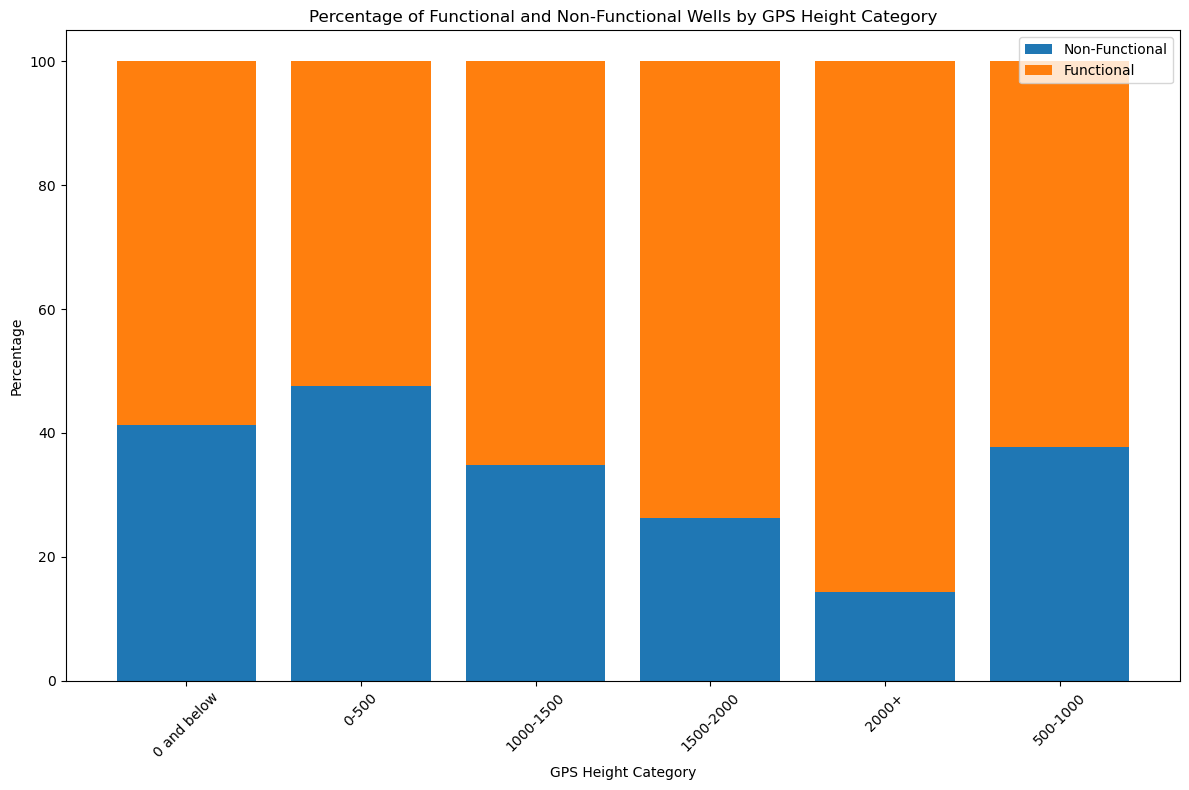

In [51]:
import matplotlib.pyplot as plt
import numpy as np

# Group the dataset by GPS height category and status group, then count the number of wells in each group
gps_height_status_countsm = merged_data.groupby(['gps_height_categorym', 'status_group_binary']).size().unstack(fill_value=0)

# Calculate the percentage of functional and non-functional wells within each GPS height subcategory
gps_height_percentages = gps_height_status_countsm.div(gps_height_status_countsm.sum(axis=1), axis=0) * 100

# Extract categories and status groups
categories = gps_height_percentages.index
status_groups = gps_height_percentages.columns

# Define bar width
bar_width = 0.8
index = np.arange(len(categories))

# Plotting
plt.figure(figsize=(12, 8))

# Plot stacked bars for each GPS height subcategory
bottom = np.zeros(len(categories))  # Initialize bottom values for stacking bars
for i, status in enumerate(status_groups):
    plt.bar(index, gps_height_percentages[status], bar_width, bottom=bottom, label='Functional' if status == 1 else 'Non-Functional')
    bottom += gps_height_percentages[status]

# Add labels, title, legend, and adjust layout
plt.xlabel('GPS Height Category')
plt.ylabel('Percentage')
plt.title('Percentage of Functional and Non-Functional Wells by GPS Height Category')
plt.xticks(index, categories, rotation=45)  # Labeling x-axis ticks with categories
plt.legend()  # Adding legend to differentiate between functional and non-functional wells
plt.tight_layout()
plt.show()



In [52]:
# Check the counts of functional and non-functional wells for each status
status_counts = merged_data['status_group_binary'].value_counts()
print(status_counts)


1    31050
0    18791
Name: status_group_binary, dtype: int64


Summary Statistics for amount_tsh:
count     49841.000000
mean        352.215854
std        2793.448736
min           0.000000
25%           0.000000
50%           0.000000
75%          30.000000
max      250000.000000
Name: amount_tsh, dtype: float64


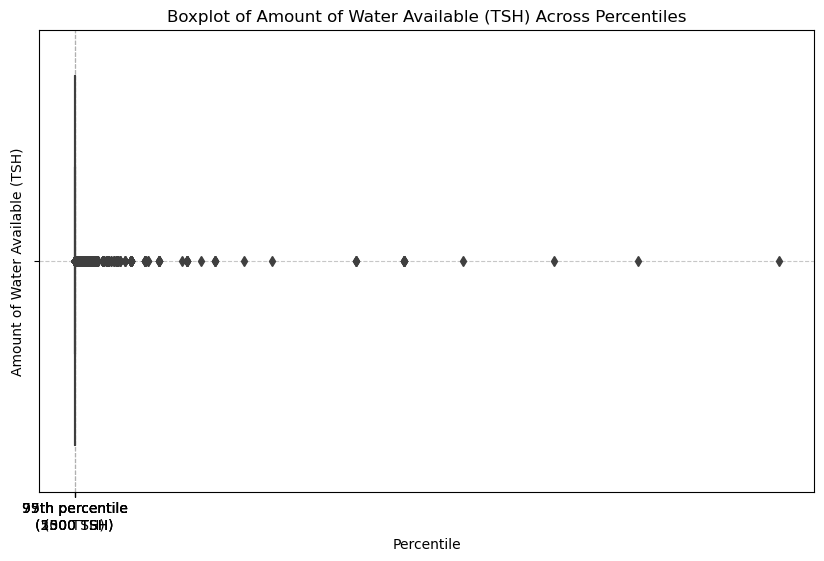

In [53]:
import matplotlib.pyplot as plt

# Summary statistics
summary_stats = merged_data['amount_tsh'].describe()
print("Summary Statistics for amount_tsh:")
print(summary_stats)

import matplotlib.pyplot as plt

import seaborn as sns

# Define the percentiles of interest
percentiles = [75, 95, 97, 99]

# Calculate the specified percentiles for amount_tsh
percentile_values = merged_data['amount_tsh'].quantile([p / 100 for p in percentiles])

# Create a boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(x=merged_data['amount_tsh'])
plt.xticks(ticks=range(len(percentiles)), labels=[f'{p}th percentile\n({int(value)} TSH)' for p, value in zip(percentiles, percentile_values)])
plt.xlabel('Percentile')
plt.ylabel('Amount of Water Available (TSH)')
plt.title('Boxplot of Amount of Water Available (TSH) Across Percentiles')
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()




In [54]:
# Calculate the number of outliers beyond each specified percentile
outliers_counts = [merged_data[merged_data['amount_tsh'] > merged_data['amount_tsh'].quantile(p / 100)].shape[0] for p in percentiles]

# Print the number of outliers
for p, outliers_count in zip(percentiles, outliers_counts):
    print(f'Number of outliers beyond the {p}th percentile: {outliers_count}')


Number of outliers beyond the 75th percentile: 12334
Number of outliers beyond the 95th percentile: 2434
Number of outliers beyond the 97th percentile: 1452
Number of outliers beyond the 99th percentile: 448


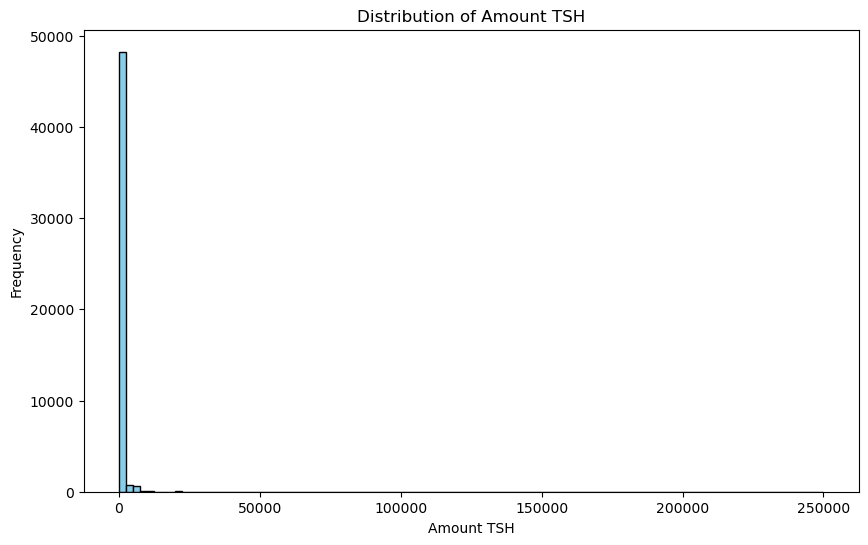

In [55]:
import matplotlib.pyplot as plt

# Set figure size
plt.figure(figsize=(10, 6))

# Plot the histogram
plt.hist(merged_data['amount_tsh'], bins=100, color='skyblue', edgecolor='black')

# Add labels and title
plt.title('Distribution of Amount TSH')
plt.xlabel('Amount TSH')
plt.ylabel('Frequency')

# Show plot
plt.show()


In [56]:
# Check for missing values in the population column
missing_population = merged_data['population'].isnull().sum()
print("Number of missing values in population:", missing_population)

# Inspect unique values in the population column
unique_population = merged_data['population'].unique()
print("Unique population:", unique_population)




Number of missing values in population: 0
Unique population: [  109   250    58     1     0   345   200    35    50     4   350   210
   156   140   260   150   180    70   100   230    30    20    10    45
   567   130   225    54    75   900   360   441   120   280    40   221
   950  1430   110   256   320    90   804   305   590   450    80   560
  2500  1050    36   540   300    12   632   245   600    32    59    25
   500   400   570   700   630   270  1000    55  1700  2530    96    86
   240   203   215    98   160  1200   309    95    60    85   159    65
    48  2150   220  1680   375  2000   125  3226   253    88   650   163
   430   290  2100   285   425   155  1500   185   115   520   800   406
   970   750   380   123   730   452  1320    14   261    82   550   348
    89   412   530   386   278   212   340   568   370    56   516  6922
   183     6   263   480  1250     8   321   420   620  5153  2353  1015
   269    44   174   323   233   258   152    42   211   855   

In [57]:
# Count the number of instances where population is 0
population_zero_count = (merged_data['population'] == 0).sum()
print("Number of instances where population is 0:", population_zero_count)


Number of instances where population is 0: 18088


To address missing values in the `population` column, I opted to utilize KNN (K-Nearest Neighbors) imputation. KNN imputation is a technique used to estimate missing values in a dataset by considering the values of nearby data points. 

In this context, KNN imputation will estimate the missing population based on the population of neighboring data points. By leveraging the similarity of neighboring observations, KNN imputation provides a reasonable approximation of the missing values.



In [58]:
from sklearn.impute import KNNImputer

# Create a KNNImputer object
imputer = KNNImputer(n_neighbors=5)  

# Select the columns containing continuous variables
continuous_columns = ['population']  
# Replace missing values with NaN
merged_data.loc[merged_data['population'] == 0, 'population'] = np.nan

# Apply KNN imputation
merged_data_imputed = imputer.fit_transform(merged_data[continuous_columns])

# Replace the original population column with the imputed values
merged_data['population'] = merged_data_imputed

# Check the results
print(merged_data['population'].isnull().sum())  # Ensure there are no missing values remaining

0


In [59]:
# Count the number of instances where population is 0
population_zero_count = (merged_data['population'] == 0).sum()
print("Number of instances where population is 0:", population_zero_count)


Number of instances where population is 0: 0


In [60]:
# Count the number of instances where gps_height is 0
gps_height_zero_count = (merged_data['gps_height'] == 0).sum()
print("Number of instances where gps_height is 0:", gps_height_zero_count)


Number of instances where gps_height is 0: 17148


In [61]:
# Count the number of instances where longitude and latitude is 0
longitude_zero_count = (merged_data['longitude'] == 0).sum()
print("Number of instances where longitude is 0:", longitude_zero_count)# Count the number of instances where longitude is 0
latitude_zero_count = (merged_data['latitude'] == 0).sum()
print("Number of instances where latitude is 0:", latitude_zero_count)


Number of instances where longitude is 0: 1336
Number of instances where latitude is 0: 0


In [62]:
# Filter the dataset to get the latitude and longitude of functional and non-functional wells
functional_wells = merged_data[merged_data['status_group_binary'] == 1]
non_functional_wells = merged_data[merged_data['status_group_binary'] == 0]

# Get the counts of functional and non-functional wells
functional_count = merged_data['status_group_binary'].value_counts()[1]
non_functional_count = merged_data['status_group_binary'].value_counts()[0]

print("Number of Functional Wells:", functional_count)
print("Number of Non-Functional Wells:", non_functional_count)



Number of Functional Wells: 31050
Number of Non-Functional Wells: 18791


In [63]:
# Filter the dataset to get the latitude and longitude of functional and non-functional wells
functional_wells = merged_data[merged_data['status_group_binary'] == 1]
non_functional_wells = merged_data[merged_data['status_group_binary'] == 0]
print("Functional Wells:")
print(functional_wells.head())

print("\nNon-Functional Wells:")
print(non_functional_wells.head())



Functional Wells:
       id  amount_tsh  gps_height  longitude   latitude  num_private  \
0   69572      6000.0        1390  34.938093  -9.856322            0   
2   34310        25.0         686  37.460664  -3.821329            0   
5    9944        20.0           0  39.172796  -4.765587            0   
10  49056         0.0          62  39.209518  -7.034139            0   
11  50409       200.0        1062  35.770258 -10.574175            0   

          basin   region  region_code  district_code  ...  extraction_type  \
0    Lake Nyasa   Iringa           11              5  ...          gravity   
2       Pangani  Manyara           21              4  ...          gravity   
5       Pangani    Tanga            4              8  ...      submersible   
10  Wami / Ruvu    Pwani           60             43  ...      submersible   
11   Lake Nyasa   Ruvuma           10              5  ...           swn 80   

   management_group                payment water_quality      quantity  \
0     

In [64]:
from sklearn.impute import KNNImputer

# Create a KNNImputer object
imputer = KNNImputer(n_neighbors=5)  

# Select the columns containing continuous variables
continuous_columns = ['longitude']  
# Replace missing values with NaN
merged_data.loc[merged_data['longitude'] == 0, 'longitude'] = np.nan

# Apply KNN imputation
merged_data_imputed = imputer.fit_transform(merged_data[continuous_columns])

# Replace the original population column with the imputed values
merged_data['longitude'] = merged_data_imputed

# Check the results
print(merged_data['longitude'].isnull().sum())  # Ensure there are no missing values remaining

0


/var/folders/6j/s4t4t49n5ns3bwtzvg_ys6xw0000gn/T/ipykernel_65998/284937305.py:14: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


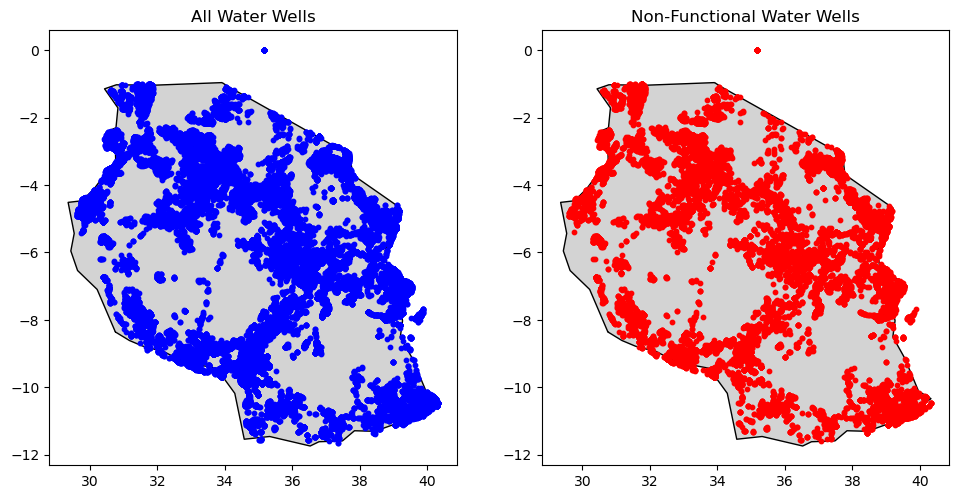

In [65]:
import geopandas as gpd
import matplotlib.pyplot as plt

# Create a GeoDataFrame for all water wells
all_wells_gdf = gpd.GeoDataFrame(merged_data, geometry=gpd.points_from_xy(merged_data.longitude, merged_data.latitude))

# Filter the data to get only non-functional water wells
non_functional_wells = merged_data[merged_data['status_group_binary'] == 0]
non_functional_wells_gdf = gpd.GeoDataFrame(non_functional_wells, geometry=gpd.points_from_xy(non_functional_wells.longitude, non_functional_wells.latitude))

# Plot the map of Tanzania with all water wells
plt.figure(figsize=(10, 5))
ax1 = plt.subplot(1, 2, 1)
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
world[world.name == 'Tanzania'].plot(ax=ax1, color='lightgrey', edgecolor='black')
all_wells_gdf.plot(ax=ax1, color='blue', markersize=10)
ax1.set_title('All Water Wells')

# Plot the map of Tanzania with non-functional water wells
ax2 = plt.subplot(1, 2, 2)
world[world.name == 'Tanzania'].plot(ax=ax2, color='lightgrey', edgecolor='black')
non_functional_wells_gdf.plot(ax=ax2, color='red', markersize=10)
ax2.set_title('Non-Functional Water Wells')

plt.tight_layout()
plt.show()


## Assessment of Zero Values in GPS Height Data
Upon discovering a significant number of zero values in the GPS height data, further investigation was conducted to determine their validity.

A histogram was created to visualize the distribution of zero values in the GPS height data.
The visualization indicated that the number of zero values is relatively equal to other values in the distribution.

Based on the visual analysis, it was concluded that the zero values in the GPS height data appear to be valid and distributed similarly to other values. Therefore, the decision was made not to remove these values from the dataset.


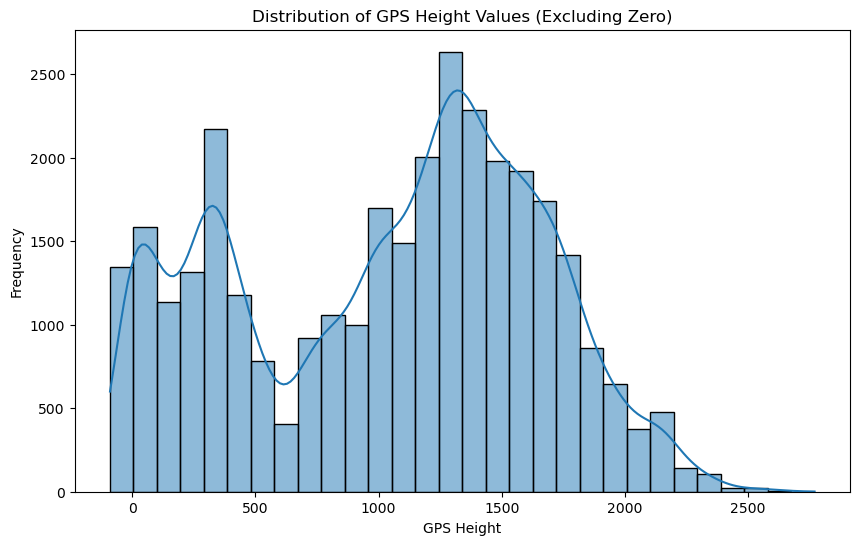

In [66]:
import seaborn as sns
import matplotlib.pyplot as plt

# Filter out zero GPS height values
non_zero_gps_height = merged_data[merged_data['gps_height'] != 0]

# Plot histogram
plt.figure(figsize=(10, 6))
sns.histplot(data=non_zero_gps_height, x='gps_height', bins=30, kde=True)
plt.title('Distribution of GPS Height Values (Excluding Zero)')
plt.xlabel('GPS Height')
plt.ylabel('Frequency')
plt.show()


In [67]:
# Count the number of instances where  0 is present in the columns
basin_zero_count = (merged_data['basin'] == 0).sum()
print("Number of instances where basin is 0:", basin_zero_count)
region_zero_count = (merged_data['region'] == 0).sum()
print("Number of instances where region is 0:", region_zero_count)
region_code_zero_code = (merged_data['region_code'] == 0).sum()
print("Number of instances where region_code is 0:", region_code_zero_code)

Number of instances where basin is 0: 0
Number of instances where region is 0: 0
Number of instances where region_code is 0: 0


In [68]:
# Count the number of instances where  0 is present in the columns
extraction_type_zero_code = (merged_data['extraction_type'] == 0).sum()
print("Number of instances where extraction_type is 0:", extraction_type_zero_code)
management_group_zero_code = (merged_data['management_group'] == 0).sum()
print("Number of instances where mangement_group is 0:", management_group_zero_code)

Number of instances where extraction_type is 0: 0
Number of instances where mangement_group is 0: 0


In [69]:
# Check the data types of each column
print(merged_data.dtypes)


id                        int64
amount_tsh              float64
gps_height                int64
longitude               float64
latitude                float64
num_private               int64
basin                    object
region                   object
region_code               int64
district_code             int64
population              float64
public_meeting           object
scheme_management        object
permit                   object
construction_year       float64
extraction_type          object
management_group         object
payment                  object
water_quality            object
quantity                 object
source                   object
waterpoint_type          object
status_group_binary       int64
decade_construction      object
gps_height_categorym     object
dtype: object


In [70]:
# Select categorical columns
categorical_columns = merged_data.select_dtypes(include=['object']).columns.tolist()
print(categorical_columns)


['basin', 'region', 'public_meeting', 'scheme_management', 'permit', 'extraction_type', 'management_group', 'payment', 'water_quality', 'quantity', 'source', 'waterpoint_type', 'decade_construction', 'gps_height_categorym']


In [71]:
print("NaNs in 'decade_construction' before Ordinal Encoding:", merged_data['decade_construction'].isnull().sum())


NaNs in 'decade_construction' before Ordinal Encoding: 0


In [72]:
# If there are NaNs and you decide to label them as 'Unknown'
merged_data['decade_construction'].fillna('Unknown', inplace=True)

# Verify categories are correctly set, including 'Unknown' if used
print("Unique categories in 'decade_construction':", merged_data['decade_construction'].unique())


Unique categories in 'decade_construction': ['1990s' '2000s' '1980s' '2010s' '1970s' '1960s']


In [73]:
from sklearn.preprocessing import OrdinalEncoder

# Define categories in the order you wish to encode them
categories = [['1960s', '1970s', '1980s', '1990s', '2000s', '2010s', 'Unknown']]  # Adjust as needed

# Initialize the OrdinalEncoder with the defined categories
ordinal_encoder = OrdinalEncoder(categories=categories)

# Fit and transform 'decade_construction'
merged_data['decade_construction_ordinal'] = ordinal_encoder.fit_transform(merged_data[['decade_construction']])


In [74]:
# Display unique decades and their encoded values
unique_decades = merged_data['decade_construction'].unique()
unique_encoded_values = merged_data['decade_construction_ordinal'].unique()

print("Unique Decades:", unique_decades)
print("Unique Encoded Values:", unique_encoded_values)

# Optionally, to see a mapping of decade to its ordinal encoding
decade_encoding_mapping = merged_data[['decade_construction', 'decade_construction_ordinal']].drop_duplicates().sort_values(by='decade_construction_ordinal')
print(decade_encoding_mapping)


Unique Decades: ['1990s' '2000s' '1980s' '2010s' '1970s' '1960s']
Unique Encoded Values: [3. 4. 2. 5. 1. 0.]
    decade_construction  decade_construction_ordinal
100               1960s                          0.0
16                1970s                          1.0
3                 1980s                          2.0
0                 1990s                          3.0
2                 2000s                          4.0
10                2010s                          5.0


In [75]:
# Dummy encode categorical columns
merged_data_encoded = pd.get_dummies(merged_data, columns=categorical_columns)

# Display the encoded dataset
print(merged_data_encoded.head())


      id  amount_tsh  gps_height  longitude   latitude  num_private  \
0  69572      6000.0        1390  34.938093  -9.856322            0   
2  34310        25.0         686  37.460664  -3.821329            0   
3  67743         0.0         263  38.486161 -11.155298            0   
5   9944        20.0           0  39.172796  -4.765587            0   
6  19816         0.0           0  33.362410  -3.766365            0   

   region_code  district_code  population  construction_year  ...  \
0           11              5  109.000000             1999.0  ...   
2           21              4  250.000000             2009.0  ...   
3           90             63   58.000000             1986.0  ...   
5            4              8    1.000000             2009.0  ...   
6           17              3  270.268888             1997.0  ...   

   decade_construction_1980s  decade_construction_1990s  \
0                          0                          1   
2                          0            

In [76]:
print(merged_data_encoded.columns)


Index(['id', 'amount_tsh', 'gps_height', 'longitude', 'latitude',
       'num_private', 'region_code', 'district_code', 'population',
       'construction_year',
       ...
       'decade_construction_1980s', 'decade_construction_1990s',
       'decade_construction_2000s', 'decade_construction_2010s',
       'gps_height_categorym_0 and below', 'gps_height_categorym_0-500',
       'gps_height_categorym_1000-1500', 'gps_height_categorym_1500-2000',
       'gps_height_categorym_2000+', 'gps_height_categorym_500-1000'],
      dtype='object', length=130)


In [77]:
# Check if 'status_group_binary' column exists in merged_data_encoded
if 'status_group_binary' in merged_data_encoded.columns:
    print("'status_group_binary' column exists in merged_data_encoded DataFrame.")
else:
    print("'status_group_binary' column does not exist in merged_data_encoded DataFrame.")


'status_group_binary' column exists in merged_data_encoded DataFrame.


In [78]:
from sklearn.model_selection import train_test_split

# Split the data into features (X) and target variable (y)
X = merged_data_encoded.drop(columns=['status_group_binary'])
y = merged_data_encoded['status_group_binary']

# Split the data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Check the shapes of the train and test sets
print("Shape of X_train:", X_train.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of y_test:", y_test.shape)




Shape of X_train: (39872, 129)
Shape of X_test: (9969, 129)
Shape of y_train: (39872,)
Shape of y_test: (9969,)


In [79]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

# Initialize the decision tree classifier
clf = DecisionTreeClassifier(random_state=42)

# Fit the classifier to the training data
clf.fit(X_train, y_train)

# Make predictions on the test data
y_pred = clf.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)


Accuracy: 0.8114153877018758


In [80]:
# Make predictions on the test data
y_pred_test = clf.predict(X_test)

# Display the first few predictions
print("Predicted labels for the test data:")
print(y_pred_test[:10])


Predicted labels for the test data:
[1 1 0 1 0 1 1 1 1 0]


In [81]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

# Split the data into features (X) and target variable (y)
X = merged_data_encoded.drop(columns=['status_group_binary'])
y = merged_data_encoded['status_group_binary']

# Split the data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the Random Forest classifier
rf_clf = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the classifier on the training data
rf_clf.fit(X_train, y_train)

# Make predictions on the test data
y_pred_rf = rf_clf.predict(X_test)



In [82]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred_rf)
print("Accuracy:", accuracy)

# Calculate precision
precision = precision_score(y_test, y_pred_rf)
print("Precision:", precision)

# Calculate recall
recall = recall_score(y_test, y_pred_rf)
print("Recall:", recall)

# Calculate F1-score
f1 = f1_score(y_test, y_pred_rf)
print("F1-score:", f1)


Accuracy: 0.8639783328317785
Precision: 0.8688299817184644
Recall: 0.920135527589545
F1-score: 0.8937470615890927


In [83]:
# Extract feature importances
feature_importances = rf_clf.feature_importances_

# Create a DataFrame to store feature importances along with their corresponding column names
feature_importance_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': feature_importances})

# Sort the DataFrame by feature importances in descending order
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Display the top 10 most important features
print(feature_importance_df.head(10))


                   Feature  Importance
4                 latitude    0.100400
3                longitude    0.097977
95            quantity_dry    0.090159
0                       id    0.075366
2               gps_height    0.050519
9        construction_year    0.038604
116  waterpoint_type_other    0.036971
8               population    0.035988
96         quantity_enough    0.032875
66   extraction_type_other    0.032291


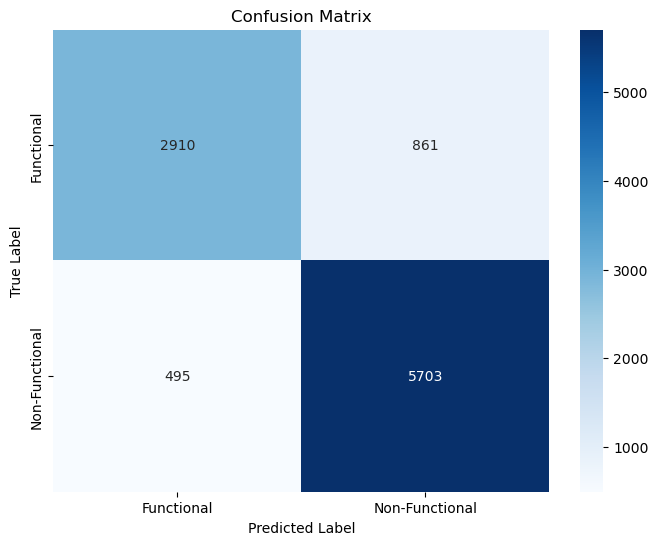

In [84]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Compute confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_rf)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", 
            xticklabels=['Functional', 'Non-Functional'],
            yticklabels=['Functional', 'Non-Functional'])
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


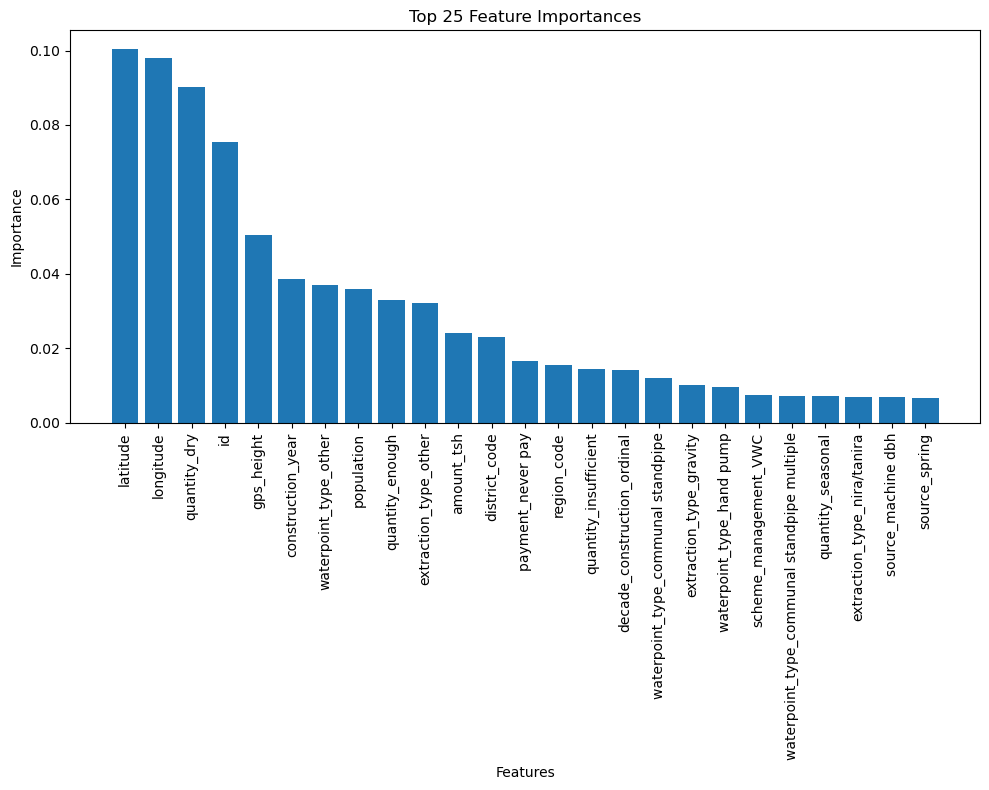

In [85]:
import matplotlib.pyplot as plt

# Get feature importances
feature_importances = rf_clf.feature_importances_
features = X_train.columns

# Sort feature importances in descending order
indices = np.argsort(feature_importances)[::-1]

# Rearrange feature names based on feature importances
sorted_features = [features[i] for i in indices]

# Plot the top 25 feature importances
plt.figure(figsize=(10, 8))
plt.title("Top 25 Feature Importances")
plt.bar(range(25), feature_importances[indices][:25], align="center")
plt.xticks(range(25), sorted_features[:25], rotation=90)
plt.xlabel("Features")
plt.ylabel("Importance")
plt.tight_layout()
plt.show()


In [86]:
# One-hot encode categorical columns
merged_data_encoded = pd.get_dummies(merged_data, columns=categorical_columns)

# Display the encoded dataset
print(merged_data_encoded.head())



      id  amount_tsh  gps_height  longitude   latitude  num_private  \
0  69572      6000.0        1390  34.938093  -9.856322            0   
2  34310        25.0         686  37.460664  -3.821329            0   
3  67743         0.0         263  38.486161 -11.155298            0   
5   9944        20.0           0  39.172796  -4.765587            0   
6  19816         0.0           0  33.362410  -3.766365            0   

   region_code  district_code  population  construction_year  ...  \
0           11              5  109.000000             1999.0  ...   
2           21              4  250.000000             2009.0  ...   
3           90             63   58.000000             1986.0  ...   
5            4              8    1.000000             2009.0  ...   
6           17              3  270.268888             1997.0  ...   

   decade_construction_1980s  decade_construction_1990s  \
0                          0                          1   
2                          0            

In [87]:
# Get the column names
columns = merged_data.columns

# Print all column names
for col in columns:
    print(col)



id
amount_tsh
gps_height
longitude
latitude
num_private
basin
region
region_code
district_code
population
public_meeting
scheme_management
permit
construction_year
extraction_type
management_group
payment
water_quality
quantity
source
waterpoint_type
status_group_binary
decade_construction
gps_height_categorym
decade_construction_ordinal


In [88]:
print(X_train.columns)


Index(['id', 'amount_tsh', 'gps_height', 'longitude', 'latitude',
       'num_private', 'region_code', 'district_code', 'population',
       'construction_year',
       ...
       'decade_construction_1980s', 'decade_construction_1990s',
       'decade_construction_2000s', 'decade_construction_2010s',
       'gps_height_categorym_0 and below', 'gps_height_categorym_0-500',
       'gps_height_categorym_1000-1500', 'gps_height_categorym_1500-2000',
       'gps_height_categorym_2000+', 'gps_height_categorym_500-1000'],
      dtype='object', length=129)


In [89]:
print(merged_data_encoded.columns)
# Import necessary libraries
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt
from sklearn import tree

# Simplify the dataset
columns_of_interest = ['status_group_binary',
                       'decade_construction_1980s', 'decade_construction_1990s',
                       'decade_construction_2000s', 'decade_construction_2010s']
simplified_data = merged_data_encoded[columns_of_interest]

# Define features and target
X_simplified = simplified_data.drop('status_group_binary', axis=1)
y_simplified = simplified_data['status_group_binary']



Index(['id', 'amount_tsh', 'gps_height', 'longitude', 'latitude',
       'num_private', 'region_code', 'district_code', 'population',
       'construction_year',
       ...
       'decade_construction_1980s', 'decade_construction_1990s',
       'decade_construction_2000s', 'decade_construction_2010s',
       'gps_height_categorym_0 and below', 'gps_height_categorym_0-500',
       'gps_height_categorym_1000-1500', 'gps_height_categorym_1500-2000',
       'gps_height_categorym_2000+', 'gps_height_categorym_500-1000'],
      dtype='object', length=130)


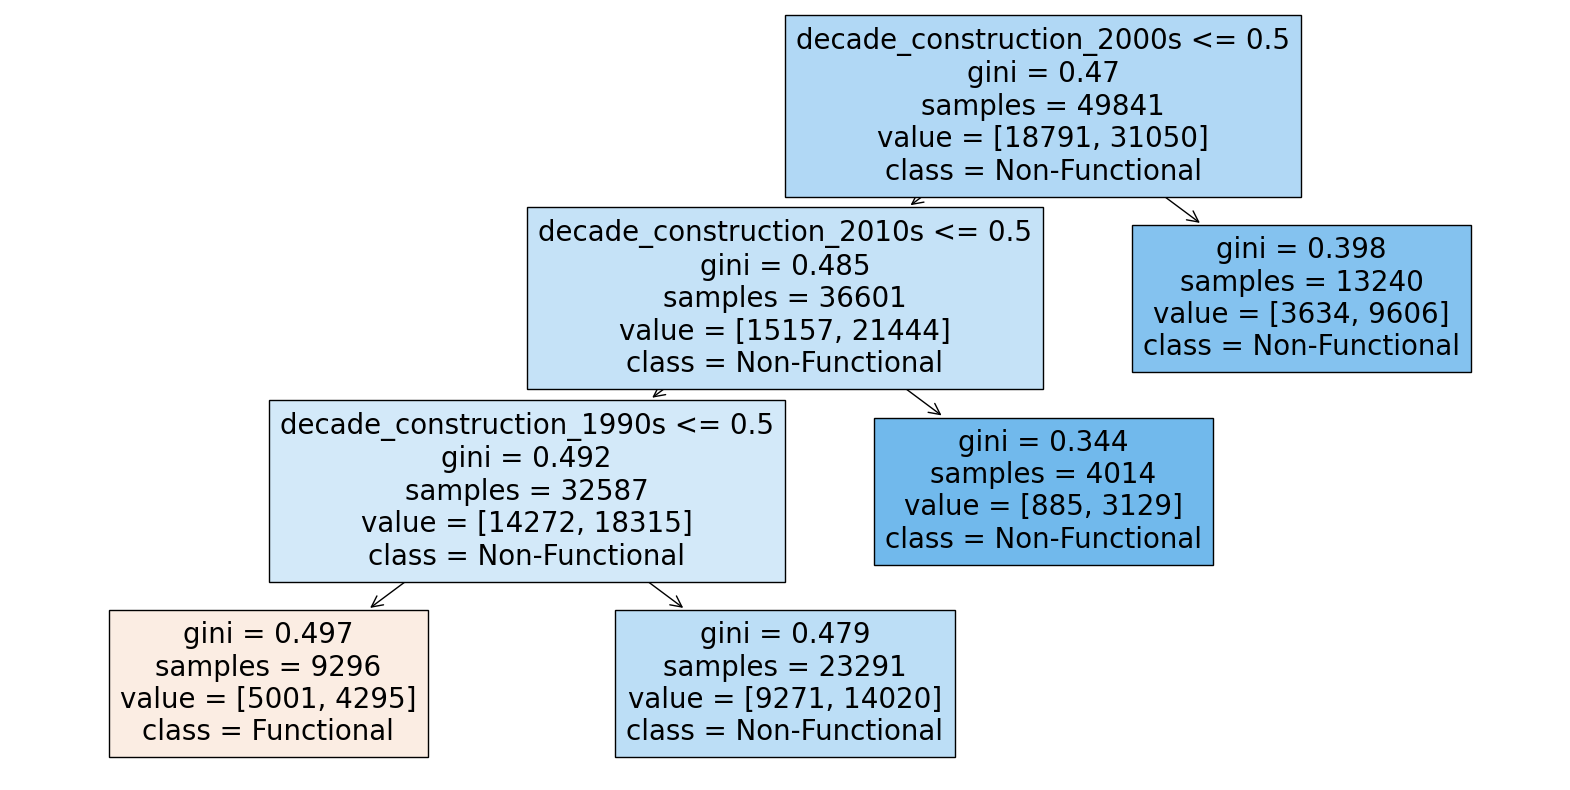

In [90]:
# Initialize and train the classifier
clf_simplified = DecisionTreeClassifier(max_depth=3, random_state=42)  # Limiting depth for visualization
clf_simplified.fit(X_simplified, y_simplified)
# Visualize the decision tree
plt.figure(figsize=(20,10))
tree.plot_tree(clf_simplified, 
               feature_names=X_simplified.columns,  
               class_names=['Functional', 'Non-Functional'],
               filled=True)
plt.show()


In [91]:
from sklearn.preprocessing import OrdinalEncoder


merged_data['decade_construction'] = pd.Categorical(merged_data['decade_construction'], 
                                                    categories=['1980s', '1990s', '2000s', '2010s'], 
                                                    ordered=True)

# Initialize the OrdinalEncoder
ordinal_encoder = OrdinalEncoder()

# Fit and transform 'decade_construction' to ordinal encoding
merged_data['decade_construction_ordinal'] = ordinal_encoder.fit_transform(merged_data[['decade_construction']])

# Now, 'decade_construction_ordinal' can be used directly in models.


ValueError: Input contains NaN

In [ ]:
# Identify rows with NaN in 'decade_construction' column
nan_rows = merged_data[merged_data['decade_construction'].isnull()]

# Display these rows
print(nan_rows)


In [ ]:
# Select categorical columns
categorical_columns = merged_data.select_dtypes(include=['object']).columns.tolist()

# Dummy encode categorical columns
merged_data_encoded = pd.get_dummies(merged_data, columns=categorical_columns)

# Check for NaNs in the encoded dataset
nan_counts = merged_data_encoded.isnull().sum()
print(nan_counts[nan_counts > 0])


In [ ]:
# Assuming 'construction_year' has already been corrected for 0s or other invalid values

# Step 1: Verify no NaNs in 'construction_year' before categorizing
print("NaNs in 'construction_year' before categorization:", merged_data['construction_year'].isnull().sum())

# Step 2: Apply categorization logic again (simplified example)
def categorize_into_decades(year):
    if year >= 1960 and year < 1970:
        return '1960s'
    # Add other conditions for different decades
    # Make sure to handle all valid cases
    else:
        return 'Unknown'  # or np.nan if you want to explicitly mark unhandled years

# Recategorize years into decades
merged_data['decade_construction'] = merged_data['construction_year'].apply(categorize_into_decades)

# Step 3: Check for NaNs in 'decade_construction' after recategorization
print("NaNs in 'decade_construction' after categorization:", merged_data['decade_construction'].isnull().sum())

# This helps in identifying at which step the issue arises
